# SDFusion: Unconditional generation and shape completion.

In [1]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [2]:
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [3]:
# import libraries
import numpy as np
from termcolor import colored, cprint
# for display
from IPython.display import Image as ipy_image
from IPython.display import display

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from datasets.dataloader import CreateDataLoader, get_data_generator
from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

In [4]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionOpt

seed = 2023
opt = SDFusionOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionTestOption initialized.


In [8]:
# initialize SDFusion model
ckpt_path = './saved_ckpt/df_steps-3000.pth'
dset="targetaugmented"
opt.init_model_args(ckpt_path=ckpt_path)
opt.init_dset_args(dataset_mode=dset)
SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
saved_ckpt/vqvae_epoch-best.pth
[*] VQVAE: weight successfully load from: saved_ckpt/vqvae_epoch-best.pth


/home/shervin.rasoulzadeh/RESEARCH_PROJECTS/UE847310/rep/SDFusion/models/sdfusion_model.py:530: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt, m

[*] weight successfully load from: ./saved_ckpt/df_steps-3000.pth
[*] setting ddim_steps=500
[*] Model has been created: SDFusion-Model
[*] "SDFusion-Model" loaded.


## 1. Unconditional Generation

Data shape for DDIM sampling is (6, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [01:06<00:00,  7.47it/s]


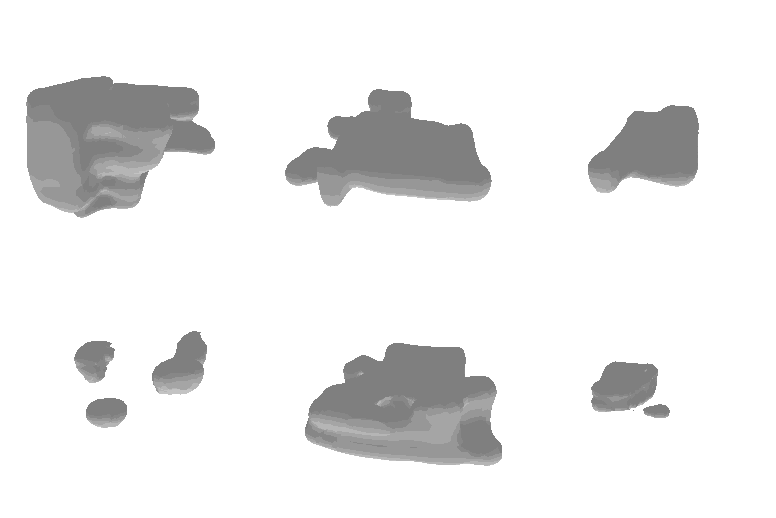

In [9]:
# unconditional generation
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

ngen = 6
ddim_steps = 500
ddim_eta = 0.

sdf_gen = SDFusion.uncond(ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta)

mesh_gen = sdf_to_mesh(sdf_gen)
print(mesh_gen)

# vis as gif
gen_name = f'{out_dir}/uncond.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

for name in [gen_name]:
    display(ipy_image(name))

In [10]:
import trimesh

for i, mesh in enumerate(mesh_gen):
    verts = mesh.cpu().verts_list()
    faces = mesh.cpu().faces_list()
    
    mesh_trimesh = trimesh.Trimesh(np.asarray(verts[0]), np.asarray(faces[0]))
    mesh_trimesh.export(f"demo_results/mesh_{i}.obj")

## 2. Shape Completion

We first prepare the input shape here. Use the xyz range `(-1 ~ 1)` to specify the missing region `(x_min, x_max, y_min, y_max, z_min, z_max)`.
The orientations are (suppose we look at the shape):
- x: left to right
- y: bottom to top
- z: back to front

For instance, setting `y_min, y_max = 0, 1` gives us the top half of the shape.

In [11]:
# initialize dataset
# dataroot = '/data01/data'
dset = 'targetaugmented'
opt.init_dset_args(dataset_mode=dset)
_, test_dl, _ = CreateDataLoader(opt)
test_ds = test_dl.dataset
test_dg = get_data_generator(test_dl)

64
[*] 1140 samples loaded.
64
[*] 1140 samples loaded.
[*] Dataset has been created: TargetAugmented-64


In [27]:
for i, test_data in enumerate(test_ds):
    if test_data['path'] == 'data/TARGETAUGMENTED/SDF/resolution_64/Doesburg_MaisonD’artiste_Master3D__Stofft_Leon_0/ori_sample_grid.h5':
        print(i)

375


{'sdf': tensor([[[[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          ...,
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]],

         [[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          ...,
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]],

         [[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,

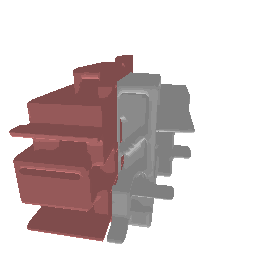

Red cuboid: missing region


In [28]:
from utils.demo_util import get_partial_shape
from utils.util_3d import combine_meshes

# 987: sofa
data_ix = 375
test_data = test_ds[data_ix]
print(test_data)

shape = test_data['sdf'].unsqueeze(0).to(device)

# specify input range. [min, max]: [-1, 1]
# default setting: given top shape.
x_min, x_max = 0, 1
y_min, y_max = -1, 1
z_min, z_max = -1, 1
xyz_dict = {'x': (x_min, x_max), 'y': (y_min, y_max), 'z': (z_min, z_max)}

# visualize input and partial shape
ret = get_partial_shape(shape, xyz_dict)
shape_part, shape_missing = ret['shape_part'], ret['shape_missing']

mesh_part = sdf_to_mesh(shape_part)
mesh_missing = sdf_to_mesh(shape_missing, color=[1, .6, .6])

# print(mesh_part)
# print(mesh_missing)

mesh_comb = combine_meshes(mesh_part, mesh_missing)
print(len(mesh_comb))
# rend_mesh_comb = render_mesh(SDFusion.renderer, mesh_comb, norm=False)

# save it
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)
sc_input_name = f'{out_dir}/shape_comp_input.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_comb, nrow=3, out_name=sc_input_name)

for name in [sc_input_name]:
    display(ipy_image(name))

print('Red cuboid: missing region')

In [30]:
import trimesh

for i, mesh in enumerate(mesh_part):
    verts = mesh.cpu().verts_list()
    faces = mesh.cpu().faces_list()
    
    mesh_trimesh = trimesh.Trimesh(np.asarray(verts[0]), np.asarray(faces[0]))
    mesh_trimesh.export(f"demo_results/mesh_180_inp.obj")

Data shape for DDIM sampling is (6, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:59<00:00,  8.46it/s]


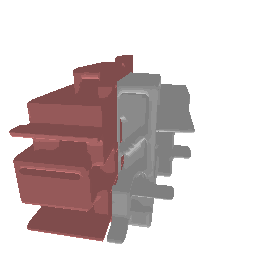

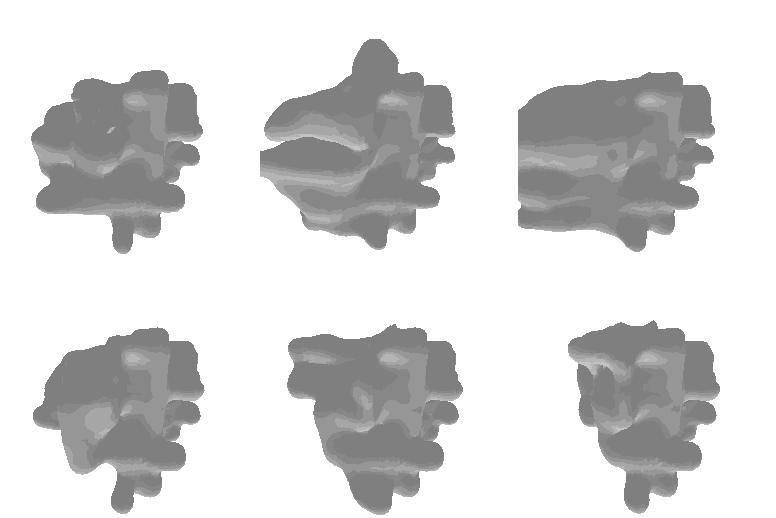

[*] Red cuboid: missing region


In [33]:
# shape completion
ngen = 6
ddim_steps = 500
ddim_eta = 0.
output_shape_comp = SDFusion.shape_comp(shape, xyz_dict, ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta)

mesh_shape_comp = sdf_to_mesh(output_shape_comp)

# vis as gif
sc_output_name = f'{out_dir}/shape_comp_output.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_shape_comp, nrow=3, out_name=sc_output_name)

for name in [sc_input_name, sc_output_name]:
    display(ipy_image(name))

print('[*] Red cuboid: missing region')

In [32]:
import trimesh

for i, mesh in enumerate(mesh_shape_comp):
    verts = mesh.cpu().verts_list()
    faces = mesh.cpu().faces_list()
    
    mesh_trimesh = trimesh.Trimesh(np.asarray(verts[0]), np.asarray(faces[0]))
    mesh_trimesh.export(f"demo_results/mesh_180_out.obj")

In [34]:
import trimesh

for i, mesh in enumerate(mesh_shape_comp):
    verts = mesh.cpu().verts_list()
    faces = mesh.cpu().faces_list()
    
    mesh_trimesh = trimesh.Trimesh(np.asarray(verts[0]), np.asarray(faces[0]))
    mesh_trimesh.export(f"demo_results/mesh_180_out.obj")